In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 4000
pd.options.display.float_format = '{:.3f}'.format 
np.set_printoptions(suppress=True, precision=5)

import warnings
warnings.filterwarnings("ignore")

In [327]:
#import
df = pd.read_csv(r'E:\learn st new\Credit score\loan_data_preprocess.csv', low_memory= False)

In [328]:
# nhóm các biến đầu vào và đầu ra thành các dataframe
input = df 
output = df['loan_ending']

## THỐNG KÊ MÔ TẢ

In [244]:
# Xử lý các biến định tính
cat_col = []
for x in input.dtypes.index:
    if input.dtypes[x] == 'object':
        cat_col.append(x)

cat_col

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'loan_ending']

In [245]:
# Nhóm các biến định lượng
num_col = []
for x in input.dtypes.index:
    if input.dtypes[x] != 'object':
        num_col.append(x)

num_col

['id',
 'loan_amnt',
 'term',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'earliest_cr_yr',
 'yr_since_last_inq',
 'yrs_of_labour']

In [280]:
input['home_ownership'] = input['home_ownership'].replace('OTHER','RENT')
input['home_ownership'] = input['home_ownership'].replace('NONE','RENT')
input['home_ownership'] = input['home_ownership'].replace('ANY','RENT')

In [281]:
#biểu đồ mô tả các biến nhân khẩu
demographic = ['grade','sub_grade','home_ownership','initial_list_status','purpose','yrs_of_labour','acc_now_delinq','term','open_acc']

def risk_pct_chart(x):
     ratio = (df.groupby(x)['loan_ending'] # group by
         .value_counts(normalize=True) # calculate the ratio
         .mul(100) # multiply by 100 to be percent
         .rename('count') # rename column as percent
         .reset_index())

     plt.figure(figsize =(15,6))
     sns.lineplot(data =ratio[ratio['loan_ending'] == 'bad'], x= x, y='count')
     plt.title(x)
     plt.show()

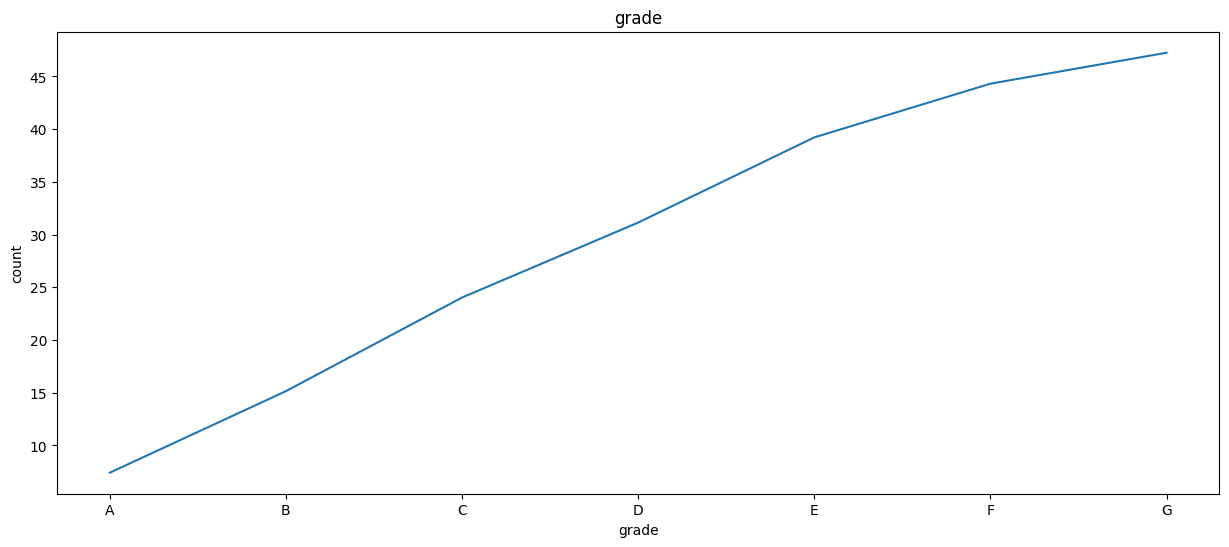

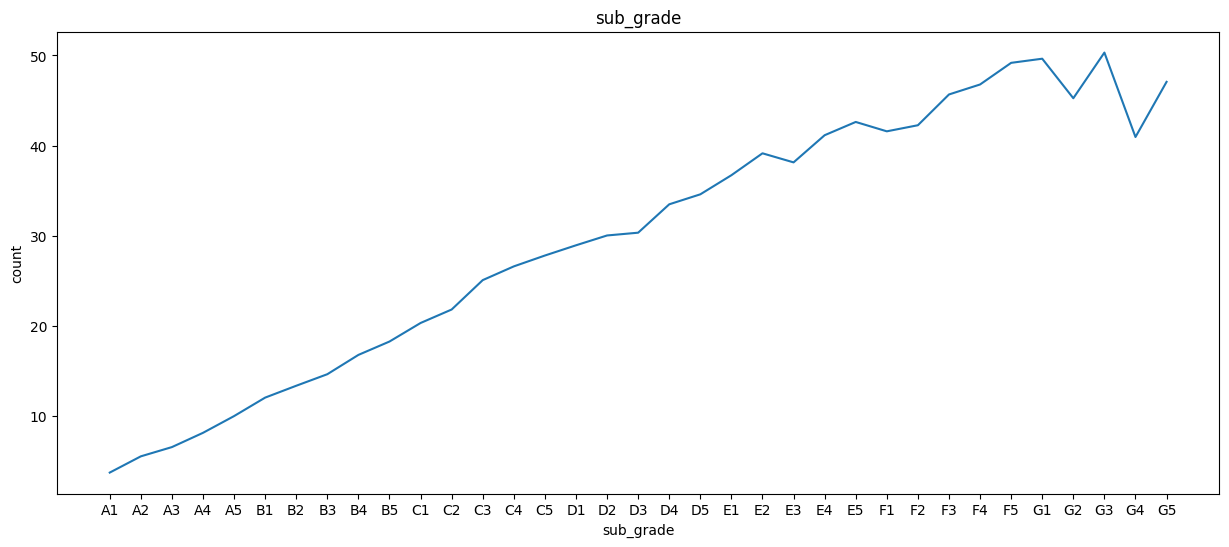

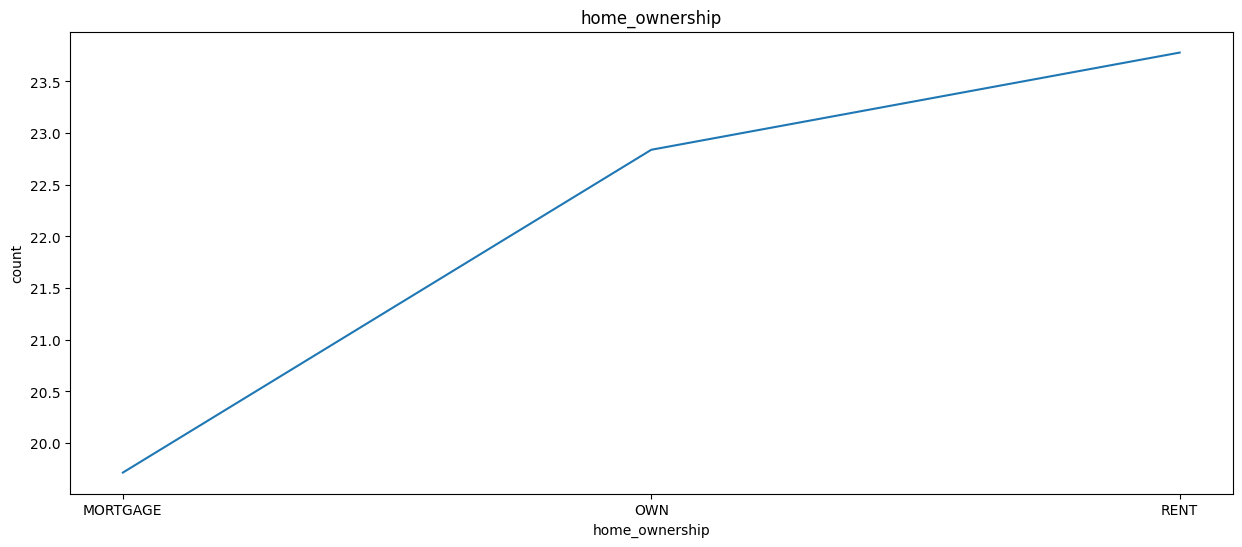

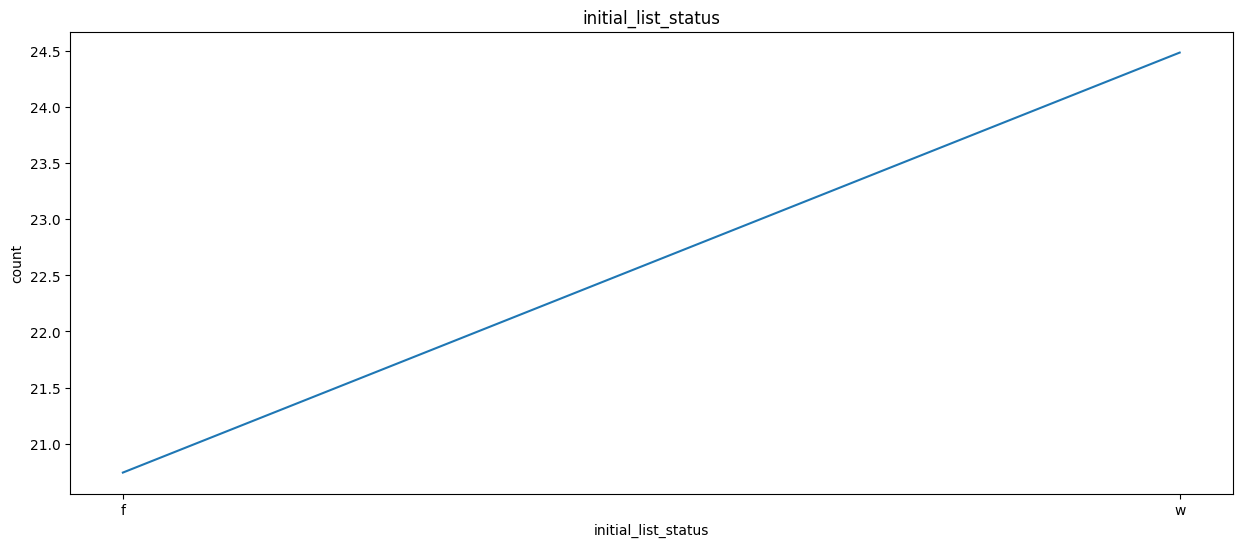

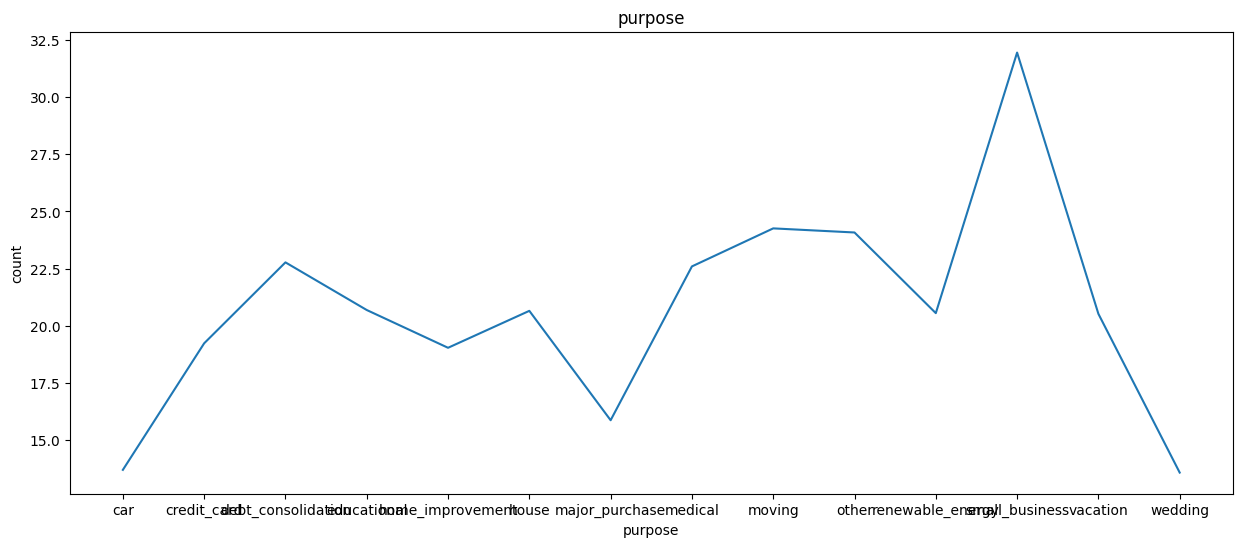

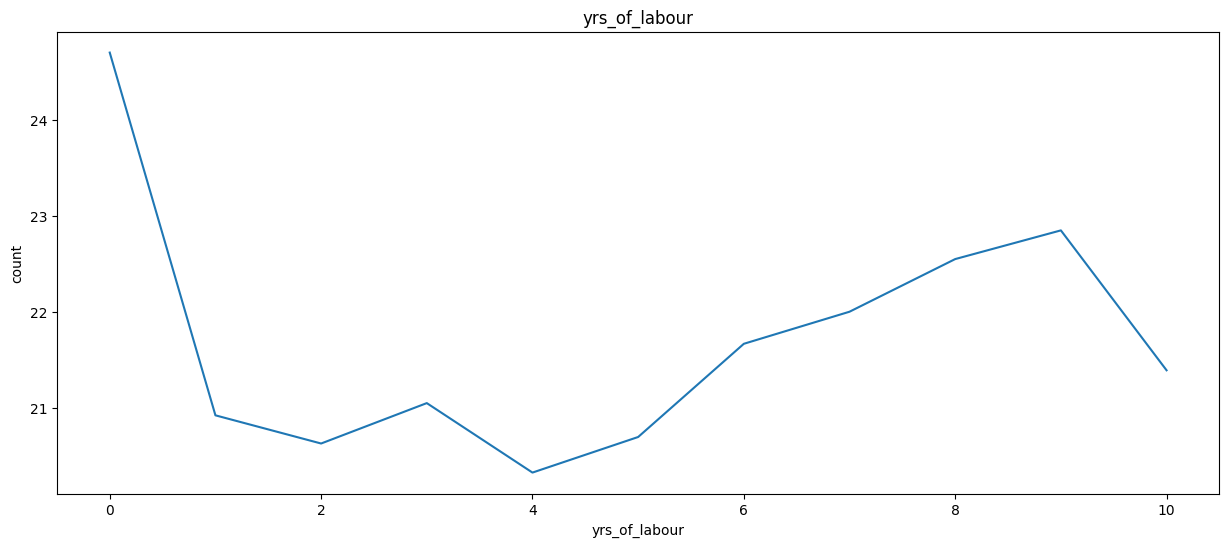

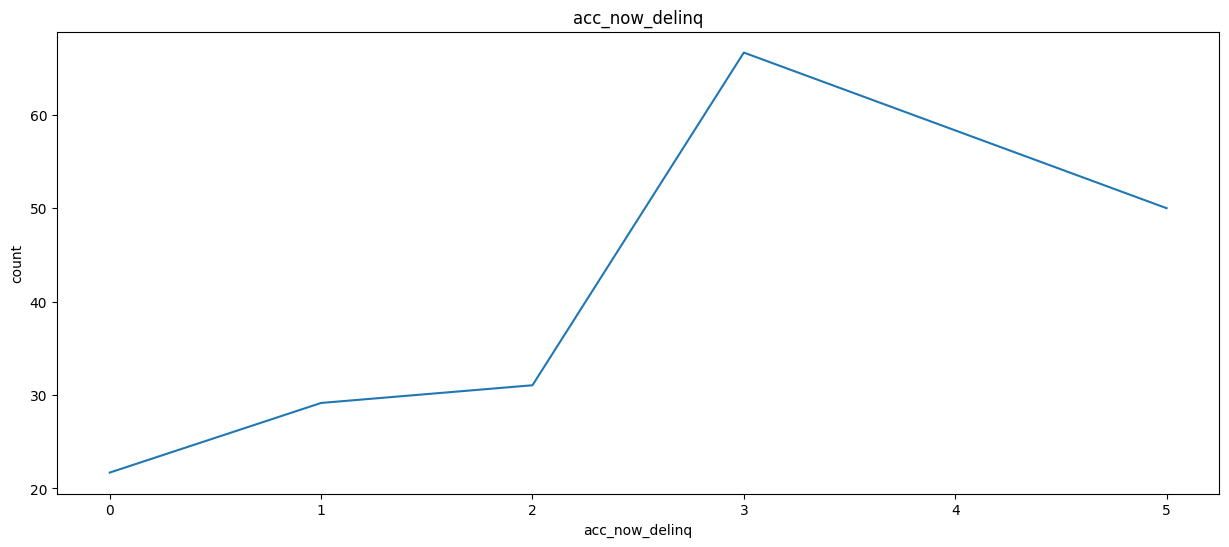

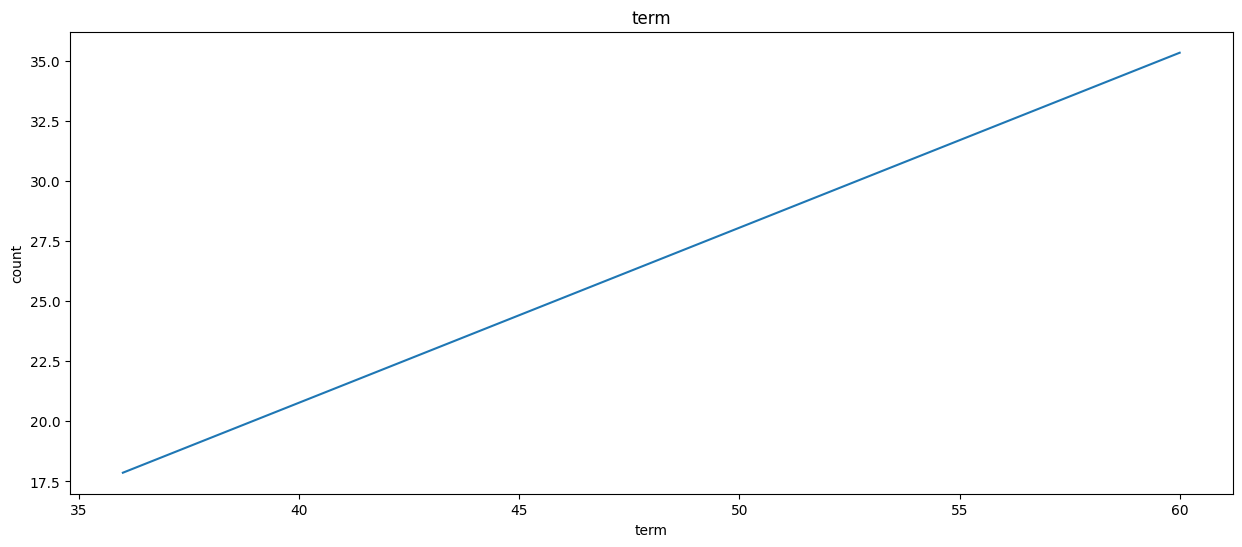

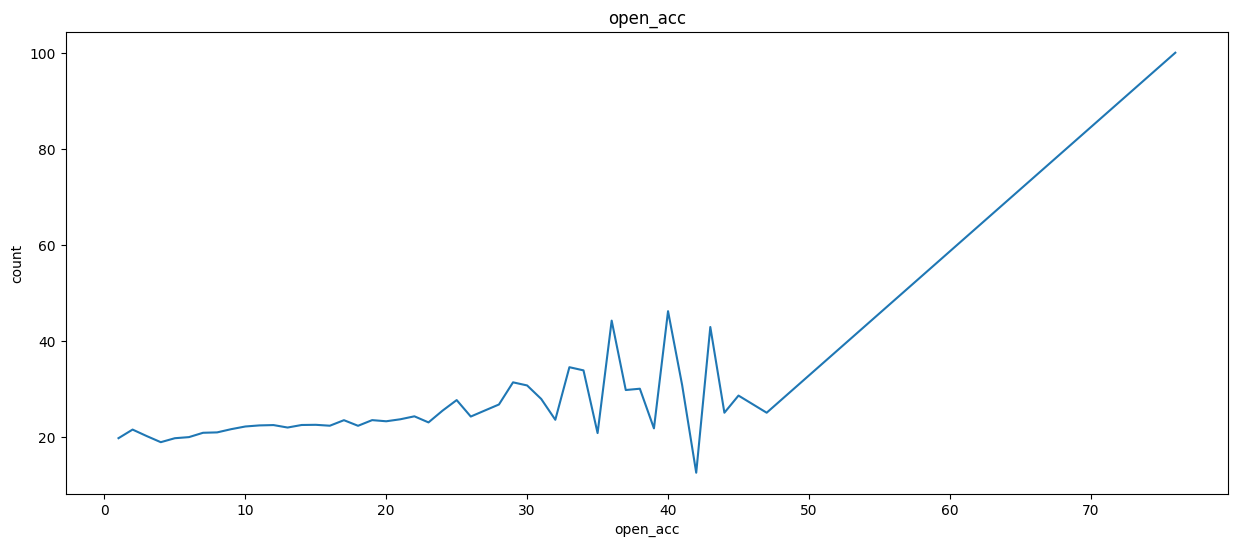

In [282]:
for cols in demographic:
    risk_pct_chart(cols)

### Nhận xét:
<li> Có sự thay đổi rõ ràng đối với nhóm term, initial list status và grade/sub_grade
<li> Đối với các nhóm nhân khẩu còn lại, sự khác biệt nằm ở trong những nhóm nhất định và sự chênh lệch là khác nhau giữa các nhóm trong cùng một biến

<Axes: >

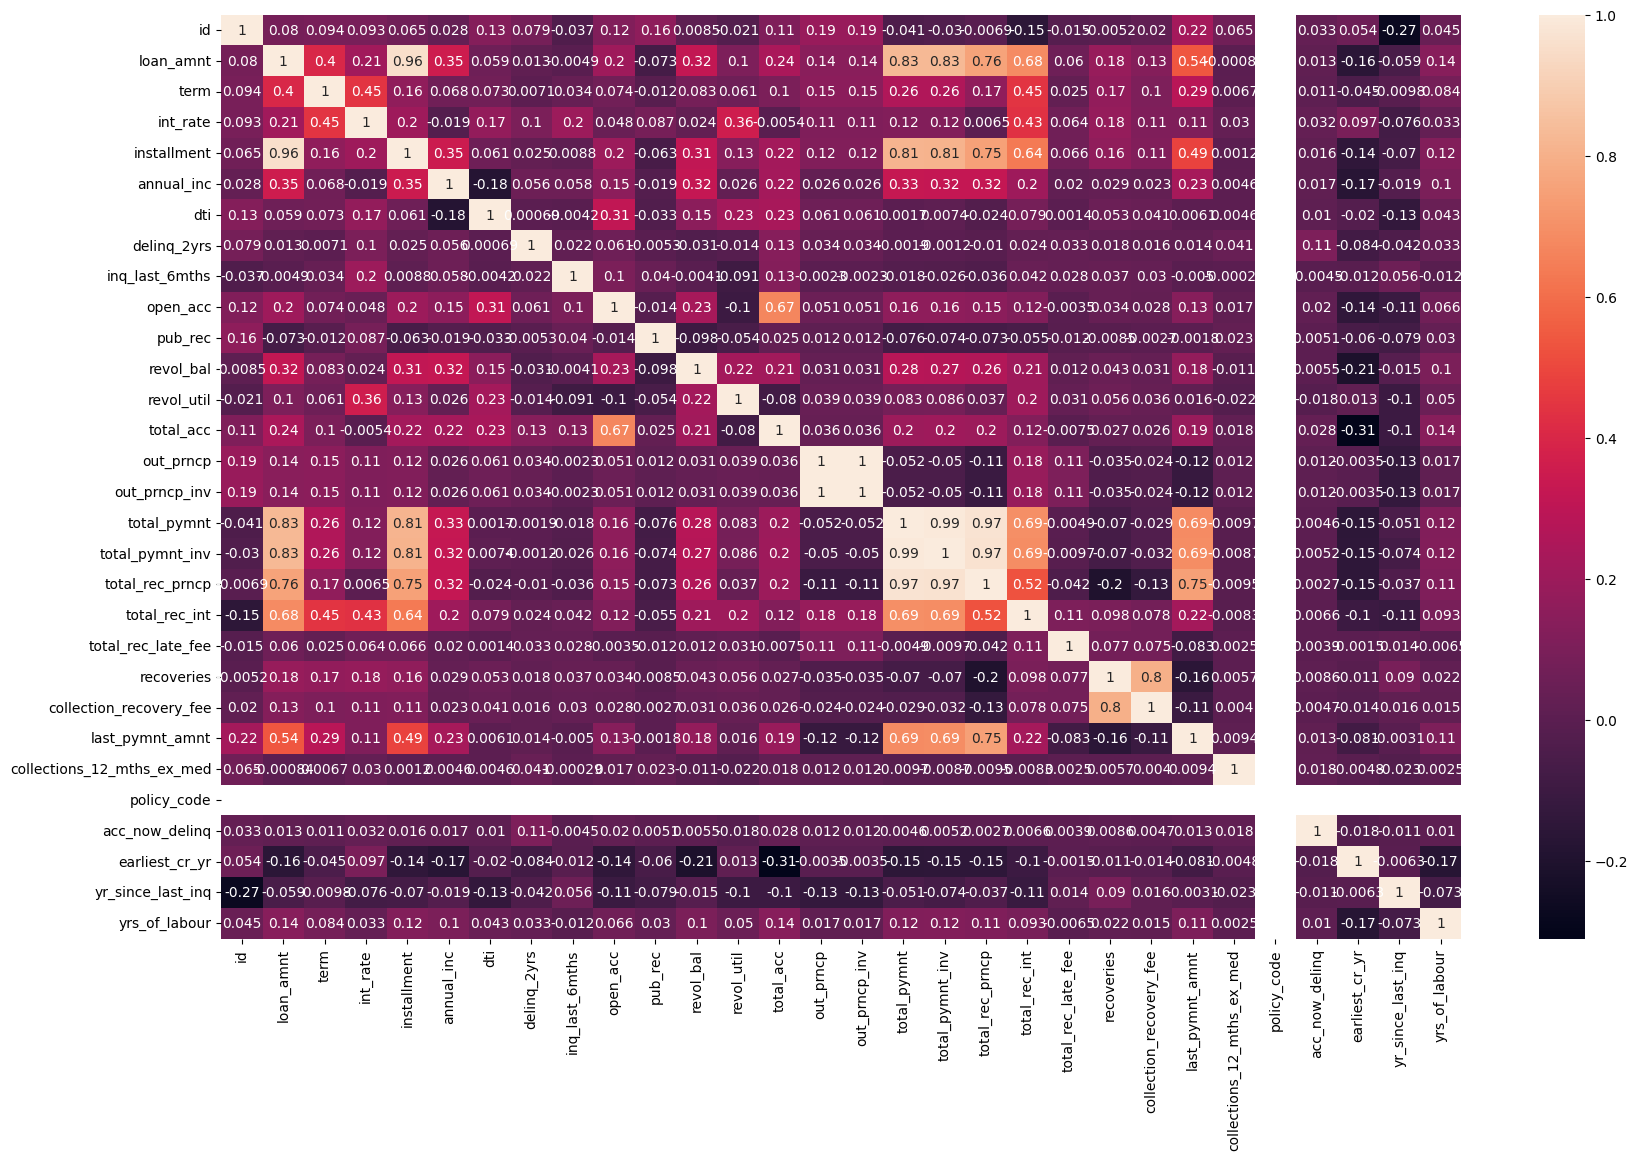

In [283]:
#Biểu đồ ma trận tương quan

plt.figure(figsize=(20,12))
sns.heatmap(data= input[num_col].corr(), annot = True)

### Nhận xét:
<li> Những biến có hệ số tương quan càng lớn, đồng nghĩa các biến đó có thể thay thế cho nhau, vì vậy nên loại bỏ 1 trong 2 biến có tương quan cao
<li> Loan_amnt có tương quan cao với installment, total_pymnt,  total_pymnt_inv,total_rec_prncp, total_rec_int. Cần loại các biến này.
<li> last_pymnt_amnt cũng có tương quan cao với loan_amnt và installment cũng như đa số các biến khác ở nhóm 2. Tuy nhiên, xem xét tới ý nghĩa của biến này, vẫn giữ lại trong mô hình
<li> recoveries và colloection_recovery_fee có tương quan cao = 0.8 nên loại 1 trong 2 biến này.
<li> total_acc và open_acc cũng có tương quan cao =0.67 nên loại 1 trong 2 biến này.

In [284]:
# Drop các columns có correlation cao
input = input.drop(columns = ['installment', 'total_pymnt','total_pymnt_inv','total_rec_prncp', 'total_rec_int', 'collection_recovery_fee','total_acc','sub_grade'])

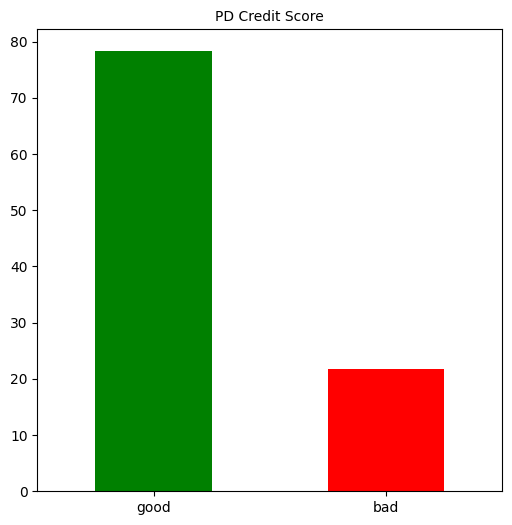

In [287]:
default_count = (output.value_counts(normalize=True)*100)
default_count.plot.bar(figsize=(6,6), color =['g','r'])
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.title("PD Credit Score", fontsize=10)
plt.show()

## Binning, Weight of Evidence (WoE), Information Value (IV)
---
Bining nhằm phân tổ các dữ liệu thành dạng category
<li>Sử dụng WoE nhằm lựa chọn các loại thành phần nên được nhóm
<li>Sử dụng IV nhằm chọn ra các features tốt nhất cho PD model

In [288]:
outpt = []
for i in range(0, len(output)):
    if output[i] == 'good':
        outpt.append(1)
    else:
        outpt.append(0)

In [289]:
outpt = pd.DataFrame(outpt, columns = ['loan_crt_score'])

In [290]:
# Tính WoE và IV cho biến định danh nominal

def woe_discrete(df,independent_variable,dependent_variable):
    df = pd.concat([df[independent_variable],dependent_variable],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].count(),
    df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis=1)
    df = df.iloc[:,[0,1,3]]
    
    df.columns = [df.columns.values[0],'n_obs','prop_good']
    df['no_good'] = df['prop_good'] * df['n_obs']
    df['no_bad'] = (1- df['prop_good']) * df['n_obs']
    df['Final_good'] = df['no_good']/df['no_good'].sum()
    df['Final_bad'] = df['no_bad']/df['no_bad'].sum()
    df['WOE'] = np.log(df['Final_good']/df['Final_bad'])

    
    df = df.sort_values(['WOE'])
    df = df.reset_index(drop=True)
    df['IV'] = (df['Final_good']-df['Final_bad']) * df['WOE']
    df['IV_total'] = df['IV'].sum()
    print('Information value of ' +independent_variable+' is '+ str(round(df['IV'].sum(),3)))
    return df


In [291]:
# Vẽ plot
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WOE']
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, marker = 'o', color = 'hotpink', linestyle = 'dashed', linewidth = 3, markersize = 18, markeredgecolor = 'cyan', markerfacecolor = 'black')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels) 
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

In [292]:
# Nhóm các biến định danh
norminal_var = ['term', 'grade','home_ownership', 'verification_status',
                'pymnt_plan', 'purpose', 'yrs_of_labour', 'yr_since_last_inq','initial_list_status']

In [293]:
for i in range(0, len(norminal_var)):
    print(woe_discrete(input,norminal_var[i],outpt))

Information value of term is 0.163
   term   n_obs  prop_good    no_good    no_bad  Final_good  Final_bad    WOE  \
0    60   52197      0.647  33748.000 18449.000       0.181      0.358 -0.679   
1    36  185463      0.821 152336.000 33127.000       0.819      0.642  0.243   

     IV  IV_total  
0 0.120     0.163  
1 0.043     0.163  
Information value of grade is 0.396
  grade  n_obs  prop_good   no_good    no_bad  Final_good  Final_bad    WOE  \
0     G   1960      0.528  1034.000   926.000       0.006      0.018 -1.173   
1     F   7292      0.557  4061.000  3231.000       0.022      0.063 -1.055   
2     E  17926      0.608 10896.000  7030.000       0.059      0.136 -0.845   
3     D  38452      0.689 26479.000 11973.000       0.142      0.232 -0.489   
4     C  60757      0.760 46158.000 14599.000       0.248      0.283 -0.132   
5     B  71956      0.849 61055.000 10901.000       0.328      0.211  0.440   
6     A  39317      0.926 36401.000  2916.000       0.196      0.057  1.

### Nhận xét
Dựa vào điều kiện IV <0.02 và >0.5 sẽ không có ý nghĩa cho mô hình dự báo, ta loại initial_list_status, yrs_of_labour, pymnt_plan, home_ownership

In [294]:
input = input.drop(columns = ['home_ownership','initial_list_status','yrs_of_labour','pymnt_plan'])

In [295]:
#months since last issue
input['issue_d'] = pd.to_datetime(input['issue_d'], format ="%Y-%m-%d")
df1 = pd.to_datetime('2016-12-31') - input['issue_d']
input['mths_since_issue'] = round(pd.to_numeric(df1/np.timedelta64(1,'M')))


# months since last credit_pull_day
df2 = pd.to_datetime('2016-12-31') - pd.to_datetime(input['last_credit_pull_d'], format ="%Y-%m-%d")
input['mths_since_last_crt_pull_day'] = round(pd.to_numeric(df2/np.timedelta64(1,'M')))


#month since last pymnt_day
df3 = pd.to_datetime('2016-12-31') - pd.to_datetime(input['last_pymnt_d'], format ="%Y-%m-%d")
input['mths_since_last_pymnt_day'] = round(pd.to_numeric(df3/np.timedelta64(1,'M')))

#Sau khi xử lý các dữ liệu ngày tháng, bỏ đi các cột chứa ngày tháng để lọc đầu vào cho mô hình

In [296]:
#Sau khi xử lý các dữ liệu ngày tháng, bỏ đi các cột chứa ngày tháng để lọc đầu vào cho mô hình

input = input.drop(columns = ['issue_d','last_credit_pull_d','last_pymnt_d'])

In [297]:
input[['inq_last_6mths','pub_rec', 'out_prncp','int_rate']].describe()

,inq_last_6mths,pub_rec,out_prncp,int_rate
count,237660.000,237660.000,237660.000,237660.000
mean,0.906,0.135,375.794,13.853
std,1.171,0.421,2331.587,4.380
min,0.000,0.000,0.000,5.420
25%,0.000,0.000,0.000,10.990
50%,1.000,0.000,0.000,13.670
75%,1.000,0.000,0.000,16.590
max,33.000,11.000,32160.380,26.060


<Axes: xlabel='out_prncp', ylabel='Density'>

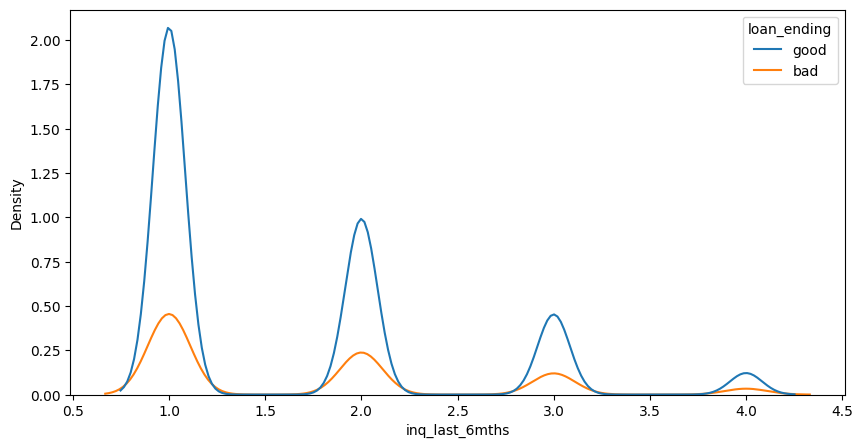

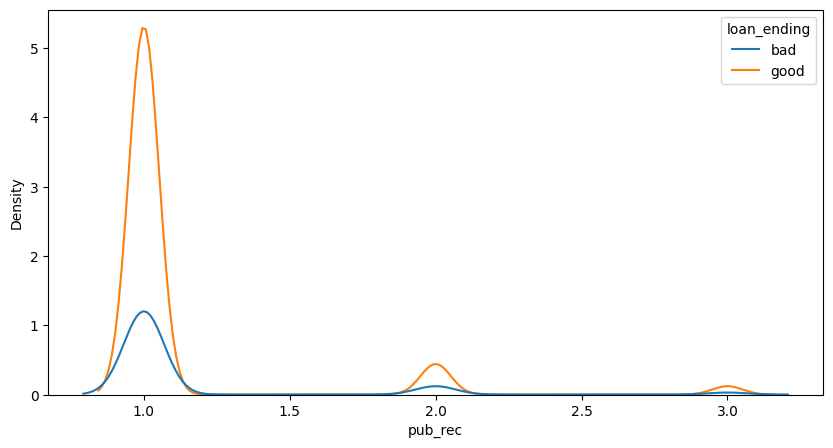

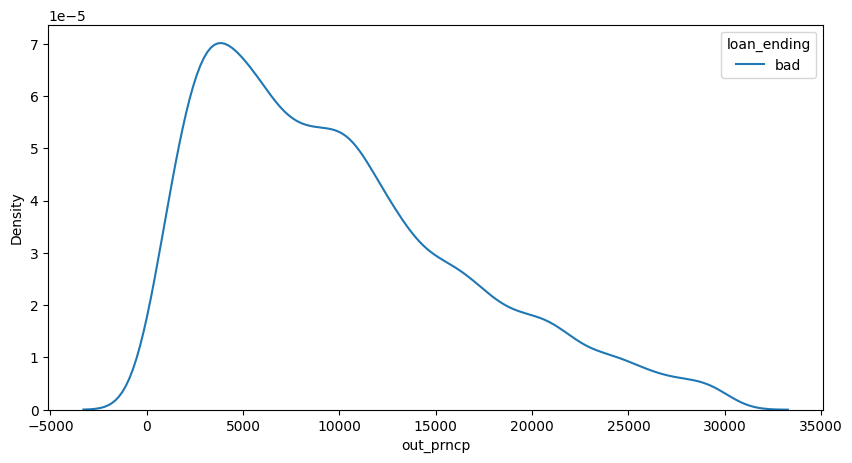

In [298]:
plt.figure(figsize = (10,5))
sns.kdeplot(data = input[(input['inq_last_6mths']< 5) &(input['inq_last_6mths'] >0) ], x ='inq_last_6mths', hue ='loan_ending')

plt.figure(figsize = (10,5))
sns.kdeplot(data = input[(input['pub_rec']<4) &(input['pub_rec'] >0) ], x ='pub_rec', hue ='loan_ending')

plt.figure(figsize = (10,5))
sns.kdeplot(data = input[(input['out_prncp']<30000) &(input['out_prncp'] >0) ], x ='out_prncp', hue ='loan_ending')



In [299]:
input = input.drop(columns = ['pub_rec','inq_last_6mths'])

### Nhận xét:
- 2 biến inq_last_month, pub_rec có phân phối khá tương đồng giữa 2 nhóm đầu ra vì vậy khó để phân loại tốt xấu giữa các đầu ra
- Biến còn lại có 100% xấu nên vẫn có thể giữ lại

In [300]:
input = input.drop(columns ='earliest_cr_line')

In [301]:
outpt = []
for i in range(0, len(output)):
    if input['loan_ending'][i] == 'good':
        outpt.append(1)
    else:
        outpt.append(0)
outpt = pd.DataFrame(outpt, columns = ['loan_crt_score'])

In [ ]:
input['loan_amnt'] = pd.cut(input['loan_amnt'],10)
input['annual_inc']= pd.cut(input['annual_inc'], 15)
input['dti'] = pd.cut(input['dti'],10)
input['acc_now_delinq'] = pd.cut(input['acc_now_delinq'], 3)
input['earliest_cr_yr'] = pd.cut(input['earliest_cr_yr'], 10)
input['yr_since_last_inq'] = pd.cut(input['yr_since_last_inq'] ,4)
input['mths_since_issue'] = pd.cut(input['mths_since_issue'], 10)
input['mths_since_last_crt_pull_day'] = pd.cut(input['mths_since_last_crt_pull_day'], 10)
input['mths_since_last_pymnt_day'] = pd.cut(input['mths_since_last_pymnt_day'], 10)
input['open_acc'] = pd.cut(input['open_acc'] ,10)
input['delinq_2yrs'] = pd.cut(input['delinq_2yrs'], 3)
input['revol_bal'] =pd.cut(input['revol_bal'], 10)
input['revol_util'] =pd.cut(input['revol_util'], 10)
input['int_rate'] = pd.cut(input['int_rate'], 10)
input['out_prncp'] =pd.cut(input['out_prncp'], 10)
input['out_prncp_inv'] = pd.cut(input['out_prncp_inv'],10)
input['recoveries'] = pd.cut(input['recoveries'], 10)
input['last_pymnt_amnt'] = pd.cut(input['last_pymnt_amnt'], 10)
input['collections_12_mths_ex_med']= pd.cut(input['collections_12_mths_ex_med', 3])

In [329]:
input['annual_inc'].describe()

count    237660.000
mean      71934.942
std       55095.067
min        1896.000
25%       45000.000
50%       61500.000
75%       86000.000
max     7141778.000
Name: annual_inc, dtype: float64

Information value of loan_amnt is 0.034


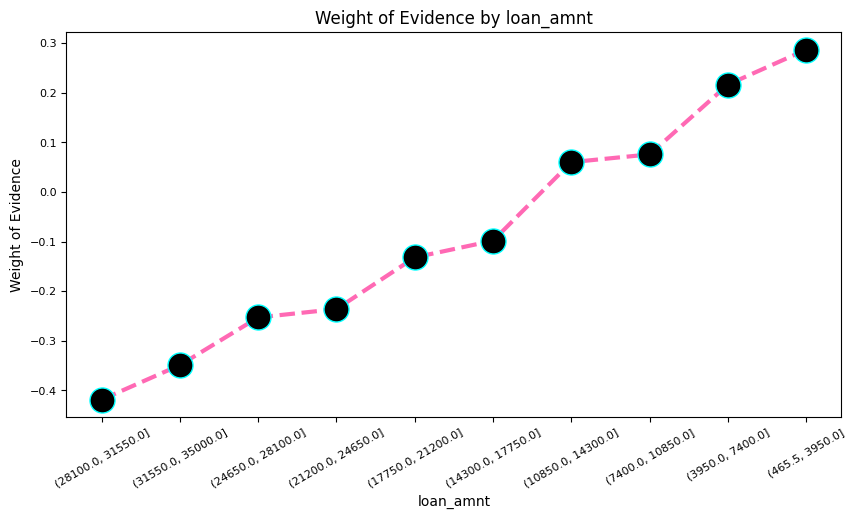

Information value of annual_inc is inf


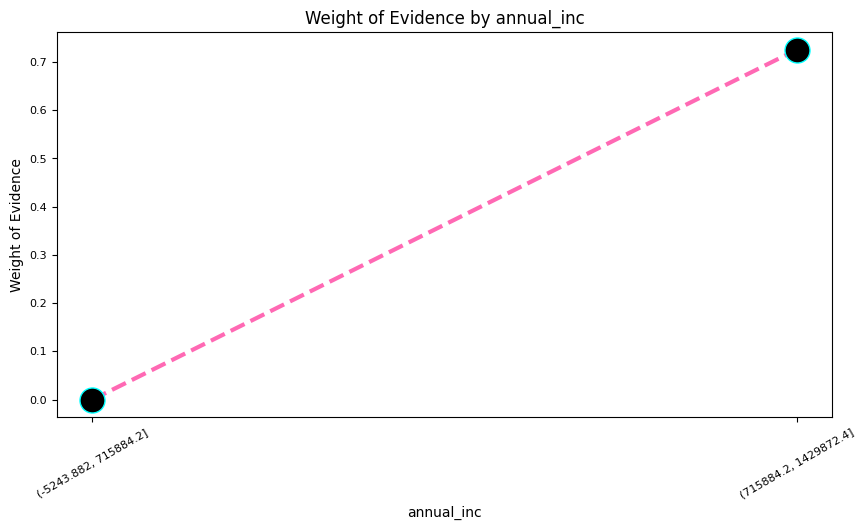

Information value of dti is 0.096


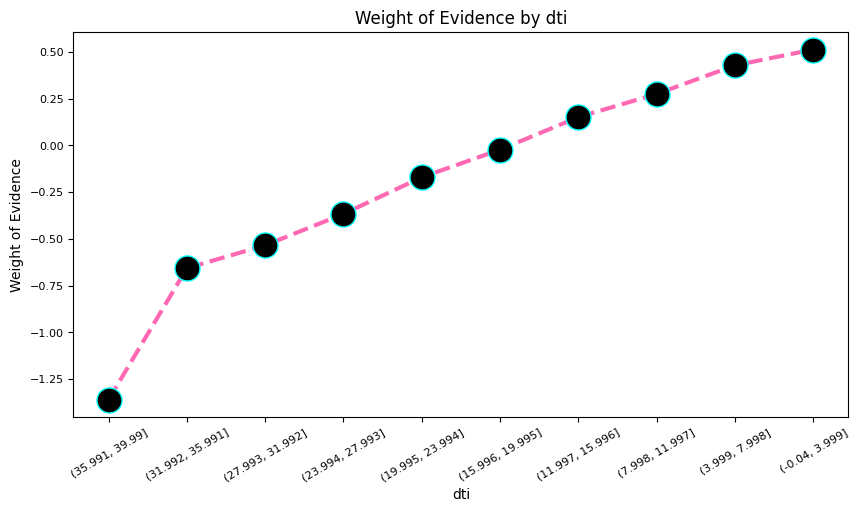

Information value of earliest_cr_yr is 0.012


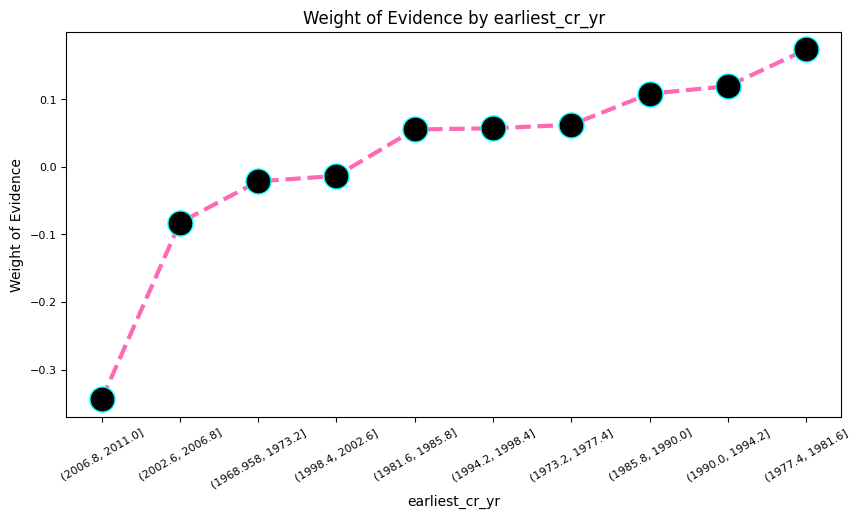

Information value of yr_since_last_inq is 0.002


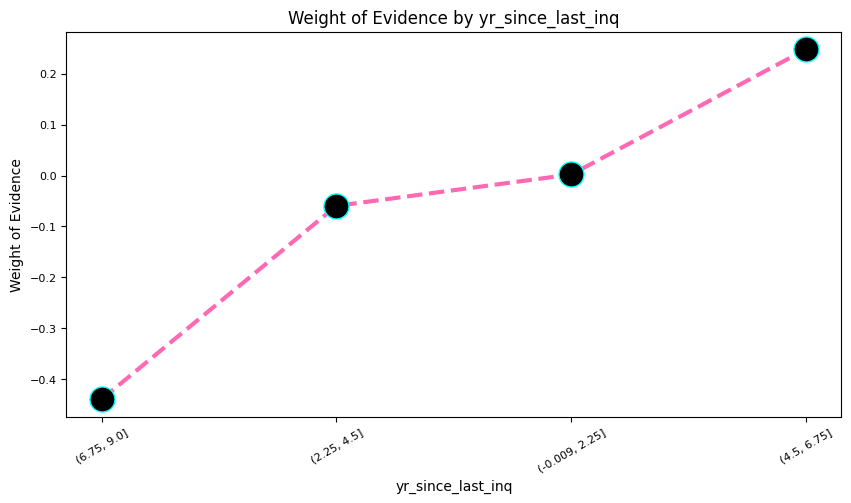

Information value of mths_since_issue is 0.072


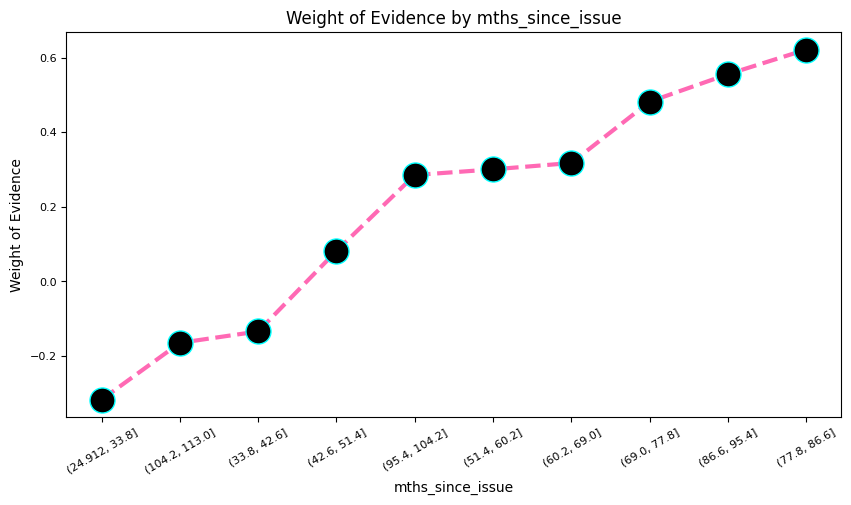

Information value of mths_since_last_crt_pull_day is 0.007


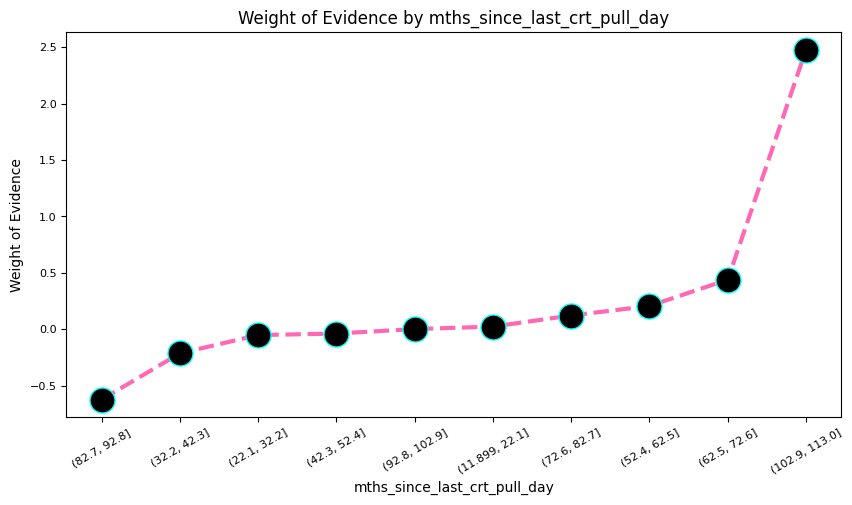

Information value of open_acc is inf


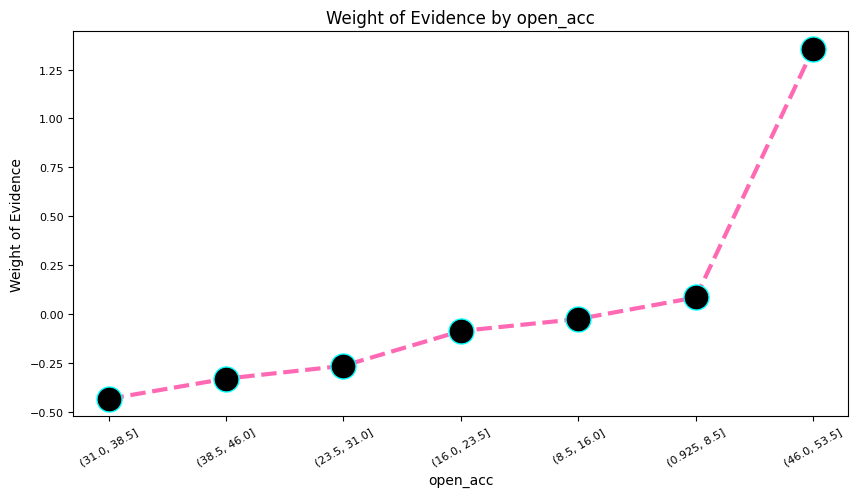

Information value of acc_now_delinq is 0.0


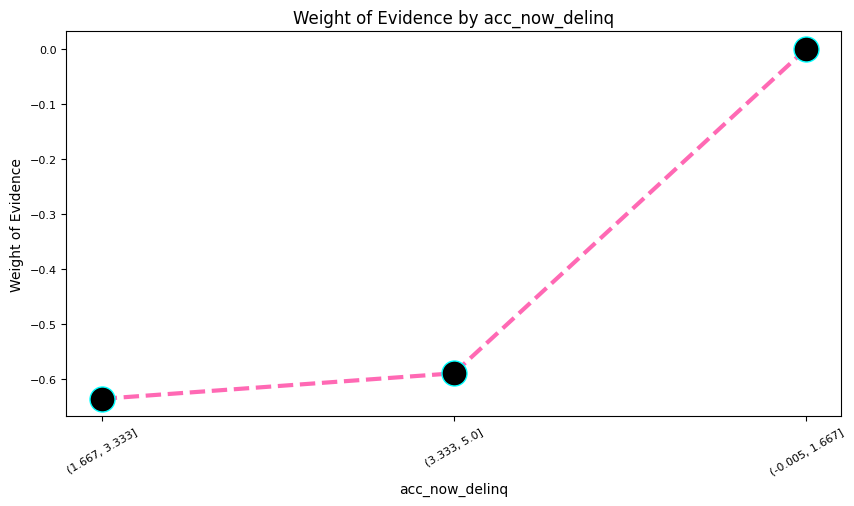

Information value of mths_since_last_pymnt_day is 0.013


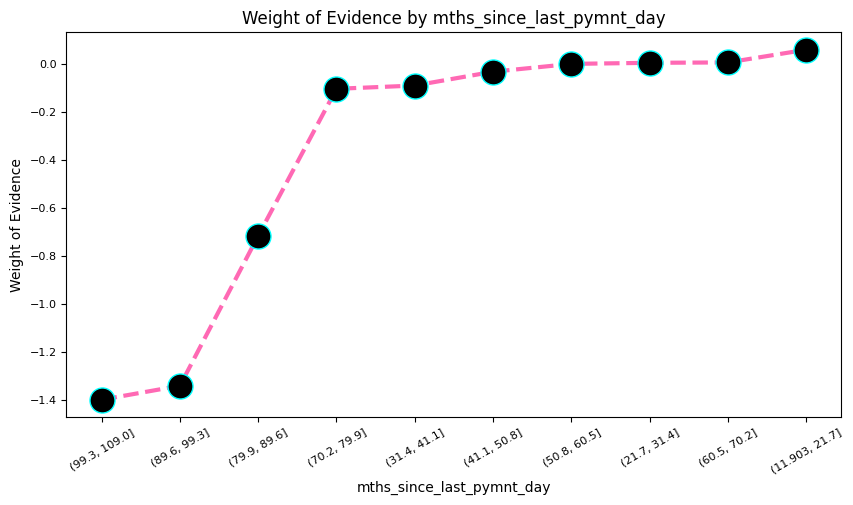

Information value of delinq_2yrs is 0.0


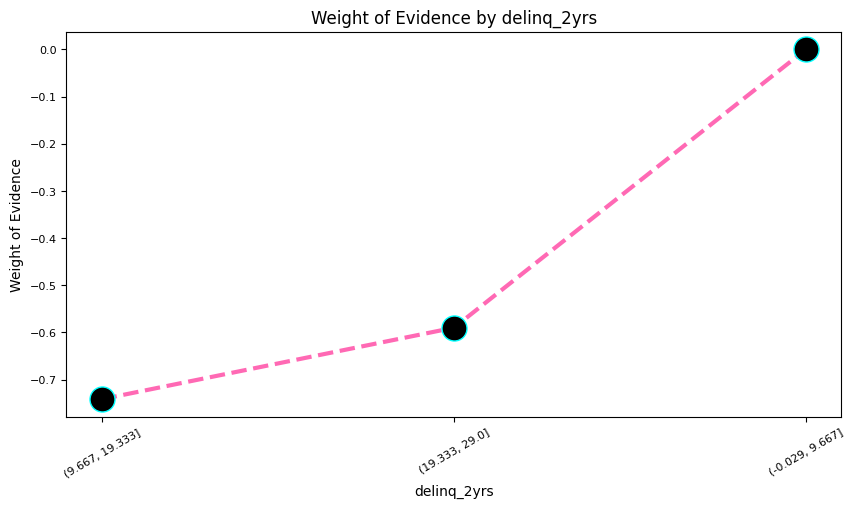

In [303]:
# woe_discrete(input, 'loan_amnt', outpt)
plot_by_woe(woe_discrete(input, 'loan_amnt', outpt), 30)
# woe_discrete(input, 'annual_inc', outpt)
plot_by_woe(woe_discrete(input, 'annual_inc', outpt), 30)
plot_by_woe(woe_discrete(input, 'dti', outpt), 30)
plot_by_woe(woe_discrete(input, 'earliest_cr_yr', outpt), 30)
plot_by_woe(woe_discrete(input, 'yr_since_last_inq', outpt), 30)
plot_by_woe(woe_discrete(input, 'mths_since_issue', outpt), 30)
plot_by_woe(woe_discrete(input, 'mths_since_last_crt_pull_day', outpt), 30)
plot_by_woe(woe_discrete(input, 'open_acc', outpt), 30)
plot_by_woe(woe_discrete(input, 'acc_now_delinq', outpt), 30)
plot_by_woe(woe_discrete(input, 'mths_since_last_pymnt_day', outpt), 30)
plot_by_woe(woe_discrete(input, 'delinq_2yrs', outpt), 30)


In [306]:
#Bỏ  delinq_2yrs, mths_since_last_pymnt_day, open_acc, yr_since_last_inq, annual_inc earliest_cr_yr acc_now_delinq 

input = input.drop(columns = ['delinq_2yrs', 'mths_since_last_pymnt_day', 'earliest_cr_yr','earliest_cr_yr','acc_now_delinq','open_acc', 'yr_since_last_inq', 'annual_inc','addr_state','id'])

In [314]:
input

,loan_amnt,term,int_rate,grade,verification_status,purpose,dti,revol_bal,revol_util,out_prncp,out_prncp_inv,total_rec_late_fee,recoveries,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,loan_ending,mths_since_issue,mths_since_last_crt_pull_day
0,"(3950.0, 7400.0]",36,10.650,B,Verified,credit_card,"(23.994, 27.993]",13648,83.700,0.000,0.000,0.000,0.000,171.620,0.000,1,INDIVIDUAL,good,"(60.2, 69.0]","(11.899, 22.1]"
1,"(465.5, 3950.0]",60,15.270,C,Source Verified,car,"(-0.04, 3.999]",1687,9.400,0.000,0.000,0.000,117.080,119.660,0.000,1,INDIVIDUAL,bad,"(60.2, 69.0]","(32.2, 42.3]"
2,"(465.5, 3950.0]",36,15.960,C,Not Verified,small_business,"(7.998, 11.997]",2956,98.500,0.000,0.000,0.000,0.000,649.910,0.000,1,INDIVIDUAL,good,"(60.2, 69.0]","(11.899, 22.1]"
3,"(7400.0, 10850.0]",36,13.490,C,Source Verified,other,"(19.995, 23.994]",5598,21.000,0.000,0.000,16.970,0.000,357.480,0.000,1,INDIVIDUAL,good,"(60.2, 69.0]","(22.1, 32.2]"
4,"(3950.0, 7400.0]",36,7.900,A,Source Verified,wedding,"(7.998, 11.997]",7963,28.300,0.000,0.000,0.000,0.000,161.030,0.000,1,INDIVIDUAL,good,"(60.2, 69.0]","(11.899, 22.1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237655,"(7400.0, 10850.0]",60,18.250,D,Verified,medical,"(11.997, 15.996]",5318,10.700,0.000,0.000,0.000,1159.400,217.650,0.000,1,INDIVIDUAL,bad,"(33.8, 42.6]","(22.1, 32.2]"
237656,"(17750.0, 21200.0]",36,7.900,A,Verified,debt_consolidation,"(7.998, 11.997]",8224,16.300,0.000,0.000,0.000,0.000,563.230,0.000,1,INDIVIDUAL,bad,"(33.8, 42.6]","(22.1, 32.2]"
237657,"(7400.0, 10850.0]",36,18.250,D,Source Verified,vacation,"(7.998, 11.997]",3196,28.800,0.000,0.000,0.000,0.000,5501.600,0.000,1,INDIVIDUAL,good,"(33.8, 42.6]","(11.899, 22.1]"
237658,"(21200.0, 24650.0]",60,19.970,D,Verified,debt_consolidation,"(15.996, 19.995]",18238,46.300,0.000,0.000,0.000,0.000,17.500,0.000,1,INDIVIDUAL,bad,"(33.8, 42.6]","(11.899, 22.1]"


In [315]:
input.to_csv('E:\learn st new\Credit score\loan_data_pd_modeling.csv', index= False)